# Project-1 N-Queen Solvers

Author: Mo Zhou <mzhou32@jhu.edu>
Date: Apr. 5 2022

## 1. Problem Description

We had lots of fun with the 8-Queens problem. In this project you will implement several search and constraint optimization algorithms for generating solutions to the 8-Queens problem. Implement four of your favorite algorithms for solving the 8-Queens problem using any language you like. Diversity in chosen search algorithms is expected. Compare their performance using appropriate metrics. 

In this project, I choose 5 algorithm for the n-queen problem:

* Naive Depth-First Search
* Backtrack Search
* Greedy Local Search
* Simulated Annealing
* Local Beam Search

See the folloinwg sections for detail. In the last section, we will benchmark these algorithms and compare their time consumption.

### 1.1. Python initialization

In this part, we import some packages that will be used later. First, we define the representation of the solution as a vector where each element indicates the Queen location (column index) in the corresponding row. For the n-queen problem, the vector size will be n, and its i-th element being j means the i-th queen locates at (i,j) position.

Given such representation, we first write a helper `cbdump()` to convert the vector representation into text checkboard for visualization.

**Note**, the random seed is fixed to (1) in order to ensure experiment reproducibility, because there will be some algorithms relying on random steps.

In [1]:
#!/usr/bin/pypy3
import time
import itertools as it
import functools as ft
import random
import math
import rich
from collections import Counter
from rich.progress import track
c = rich.get_console()
random.seed(1)


def cbdump(v: list) -> str:
    '''
    Construct a textural representation of the checkboard.
    '''
    n = len(v)
    rows = [['Q ' if v[i]==j else '. ' for j in range(n)] for i in range(n)]
    rows = '\n'.join([''.join(row) for row in rows])
    return rows

## 2. Naive Deep First Search

### 2.1 solution checker

To begin with, we need to write a solution checker. Given a vector of length n, we need to tell whether this vector presents a valid solution to the nqueen problem.

Specifically, the checker will validate (1) whether the given solution is complete. In other words, whether the vector length is n; (2) whether there is column attack; (3) whether there is diagonal attack. If there is no attack at all after all the checks, and the solution is complete, then the checker returns True. Otherwise the checker will return false because the vector is not a valid complete solution.

In [2]:
def isvalid(v: list, n: int = None, debug: bool = False) -> bool:
    '''
    Tells whether the given vector `v` is a valid solution for n-queen.
    The vector is a row-based representation of the checkboard.
    v[0] == 0 means the queen for the first row is placed at the first column.
    '''
    # dealing with convenience call
    if v and (n is None):
        n = len(v)
    # helper function for checking diagonal attack
    def _diag_attack(_v: list, debug: bool = False):
        c = Counter(i - _v[i] for i in range(len(_v)))
        return any(count > 1 for count in c.values())
    # check1: completeness
    if len(v) < n:
        if debug:
            print('Reason: incomplete', len(v), n)
        return False
    # check2: column attack
    # note, row representation is free from row attack
    if not all(x <= 1 for x in Counter(v).values()):
        if debug:
            print('Reason: column attack', Counter(v))
        return False
    # check3: diagonal attack
    if _diag_attack(v, debug) or _diag_attack(list(reversed(v)), debug):
        if debug:
            print('Reason: diagonal attack')
        return False
    # passed all checks
    return True

Next we want to write some unit tests for the solution checker to ensure correctness. And we will execute the tests.
From the tests, we can see that the solution checker `isvalid()` is able to correctly identify the reason why the solution is invalid.

*To be honest, unit test is a very good practice in software engineering.*

In [3]:
def test_isvalid():
    sol = [x-1 for x in [5,3,1,7,2,8,6,4]]
    #c.print(cbdump(sol))
    assert(isvalid(sol, debug=True))
    sol = [x-1 for x in [1,1,1,1,1,1,1,1]]
    #c.print(cbdump(sol))
    assert(not isvalid(sol, debug=True))
    sol = [x-1 for x in [1,2,3,4,5,6,7,8]]
    #c.print(cbdump(sol))
    assert(not isvalid(sol, debug=True))
    return True
test_isvalid()

Reason: column attack Counter({0: 8})
Reason: diagonal attack


True

### 2.2. Implement Naive deep first search

We implement this in a recursive manner. This is a brute-force method.
It traverses the whole search tree, and evaluate the solution at the leaf nodes. Only when it reaches a valid solution, it will return the valid solution. It is expected to be slow with python.

In [4]:
def solve_nqueen_dfs(n: int):
    '''
    Naive n-queen solver in dfs, brute-force permutation method.
    '''
    def _solve_nqueen_dfs(v: list, n: int):
        '''
        recursive worker function
        '''
        cursor = len(v)
        # recursion boundary: validate solution
        if cursor == n:
            if isvalid(v):
                return v
            else:
                return False
        # not yet reached at leaf node
        else:
            for i in range(n):
                v.append(i)
                ret = _solve_nqueen_dfs(v, n)
                if ret:
                    return ret
                else:
                    v.pop()
    return _solve_nqueen_dfs([], n)

Now we want to try to solve 8-queen with it. The result looks good and valid.

In [5]:
v = solve_nqueen_dfs(8)
c.print(cbdump(v))

Q . . . . . . . 
. . . . Q . . . 
. . . . . . . Q 
. . . . . Q . . 
. . Q . . . . . 
. . . . . . Q . 
. Q . . . . . . 
. . . Q . . . .

## 3. Backtrack search

Now we try the backtrack search. It is an extended version of depth-first search (DFS). The DFS algorithm will blindly reach all the leafs even if there is already attacks in the path it has went through. As a result, DFS is wasting traversal time for invalid leafs.

Backtrack search is to prune invalid search subtrees by skipping them once there is attack in the path it has gone through. The code is very similar to DFS but please note the key difference:

```
<<<<<<< DFS
            for i in range(n):
                v.append(i)
                ret = _solve_nqueen_dfs(v, n)
                if ret:
                    return ret
                else:
                    v.pop()
=======
            for i in range(n):
                v.append(i)
                if not isvalid(v):
                    # prune the search sub tree
                    v.pop()
                else:
                    ret = _solve_nqueen_backtrack(v, n)
                    if ret:
                        return ret
                    else:
                        v.pop()
>>>>>>> Backtrack
```

In [6]:
def solve_nqueen_backtrack(n: int):
    '''
    backtrack depth-first search for n-queen
    '''
    def _solve_nqueen_backtrack(v: list, n: int):
        '''
        recursive worker function
        '''
        cursor = len(v)
        # recursion boundary: validate solution
        if cursor == n:
            if isvalid(v):
                return v
            else:
                return False
        # not yet reached at leaf node
        else:
            for i in range(n):
                v.append(i)
                if not isvalid(v):
                    # prune the search sub tree
                    v.pop()
                else:
                    ret = _solve_nqueen_backtrack(v, n)
                    if ret:
                        return ret
                    else:
                        v.pop()
    return _solve_nqueen_backtrack([], n)

Now we want to try it out. The result is correct.

In [7]:
v = solve_nqueen_backtrack(8)
c.print(cbdump(v))

Q . . . . . . . 
. . . . Q . . . 
. . . . . . . Q 
. . . . . Q . . 
. . Q . . . . . 
. . . . . . Q . 
. Q . . . . . . 
. . . Q . . . .

## 4. Greedy Local Search

### 4.1. Attack Score function

To implement local search methods, we need an attack_score function which evaluates the total number of attacks in a proposed solution vector. Ideally, the solution should have 0 attack score. During local search, our goal is to minimize attack score function to 0 from some random guess as starting points.

In [8]:
def attack_score(v: list) -> int:
    '''
    Gives an attack score for the complete or partial solution v.
    This function is a variant to the previous `isvalid(...)` function.
    When attack_score(...) reached at 0, the given solution is valid.
    '''
    attacks = 0
    # helper function for counting diagonal attack
    def _diag_attack(_v: list) -> int:
        c = Counter(i - _v[i] for i in range(len(_v)))
        return sum(max(count-1,0) for count in c.values())
    # type1: column attack
    attacks += sum(max(x-1, 0) for x in Counter(v).values())
    # type2: diagonal attack
    attacks += _diag_attack(v)
    attacks += _diag_attack(list(reversed(v)))
    return attacks

Now we write some unit tests to ensure its corrrectness.

In [9]:
def test_attack_score():
    sol = [x-1 for x in [5,3,1,7,2,8,6,4]]
    assert(attack_score(sol) == 0)
    sol = [x-1 for x in [1,1,1,1,1,1,1,1]]
    assert(attack_score(sol) == 7)
    sol = [x-1 for x in [1,2,3,4,5,6,7,8]]
    assert(attack_score(sol) == 7)
    return True
test_attack_score()

True

### 4.2. Implement Greedy Local Search

This algorithm starts with a random guess. We define a move as a swap operation to swap two elements in the guessed solution vector. Then we evaluate possible moves to see whether there is any possible move can lead to a lower attack score. If there is such move, we apply that move and go to the next iteration. If none of possible moves could minimize the score to zero, we are stuck in a local minima, and we need to restart the algorithm with a new random guess.

In [10]:
def solve_nqueen_hill(n: int, numretry: int = 10):
    '''
    Hill-climbing (steepest) search / Greedy local search.
    We want to minimize attack_score starting from a random guess.
    '''
    def _solve_nqueen_hill(v: list, n: int, debug: bool = False):
        def _action_score(v: list, act: tuple) -> int:
            '''
            evaluate the score after performing the action
            '''
            tmp = v.copy()
            tmp[act[0]], tmp[act[1]] = tmp[act[1]], tmp[act[0]]
            return attack_score(tmp)
        for iteration in range(n):
            # evaluate the current attack_score
            current_score = attack_score(v)
            if debug:
                print('iter', iteration, 'currernt score', current_score)
            # evaluate 
            action_scores = [(action, _action_score(v, action))
                    for action in it.combinations(range(n), 2)]
            action_scores.sort(key=lambda x: x[1])  # smallest goes to top
            if debug:
                print(action_scores)
            # is there any better solution?
            if action_scores[0][1] < current_score:
                # take the action
                act = action_scores[0][0]
                v[act[0]], v[act[1]] = v[act[1]], v[act[0]]
                print('swapped', act, 'and the result is', v)
                current_score = action_scores[0][1]
            else:
                break
        return v, current_score
    # initliaze with a random guess
    # we use a fixed random seed to ensure reproducibility
    for itry in range(numretry):
        v = list(range(n))
        random.shuffle(v)
        print('trial', itry, 'starts with', v)
        sol, score = _solve_nqueen_hill(v, n, False)
        if score > 0:
            print('trial', itry, 'stuck in local minima')
        else:
            return v
    return None

Then let's try it out.

In [11]:
v = solve_nqueen_hill(8)
c.print(cbdump(v))

trial 0 starts with [3, 6, 1, 5, 7, 0, 4, 2]
swapped (0, 1) and the result is [6, 3, 1, 5, 7, 0, 4, 2]
trial 0 stuck in local minima
trial 1 starts with [2, 6, 4, 0, 1, 3, 5, 7]
trial 1 stuck in local minima
trial 2 starts with [2, 5, 1, 7, 0, 4, 3, 6]
swapped (1, 5) and the result is [2, 4, 1, 7, 0, 5, 3, 6]
swapped (5, 7) and the result is [2, 4, 1, 7, 0, 6, 3, 5]


. . Q . . . . . 
. . . . Q . . . 
. Q . . . . . . 
. . . . . . . Q 
Q . . . . . . . 
. . . . . . Q . 
. . . Q . . . . 
. . . . . Q . .

## 5. Simulated Annealing

This algorithm also starts with a random guess. Then we propose a random move and evaluate whether it reduces the attack score. If it reduces the attack score, we take the proposal. If not, we will still take the proposal with a given probability.

In my implementation, the given probability is linearly decreasing. Namely it is simply current iteration number divided by the maximum iteration of the algorithm.

In [12]:
def solve_nqueen_simanneal(n: int, numretry: int = 10):
    '''
    Simulated Annealing, another local search method.
    '''
    def _solve_nqueen_simanneal(v: list, n: int, maxiter: int = 1000,
            debug: bool = False):
        def _action_score(v: list, act: tuple) -> int:
            '''
            evaluate the score after performing the action
            '''
            tmp = v.copy()
            tmp[act[0]], tmp[act[1]] = tmp[act[1]], tmp[act[0]]
            return attack_score(tmp)
        for iteration in range(maxiter):
            # evaluate the current attack_score
            current_score = attack_score(v)
            if debug:
                print('iter', iteration, 'currernt score', current_score)
            # evaluate 
            act = random.choice(list(it.combinations(range(n), 2)))
            score = _action_score(v, act)
            # is there any better solution?
            if score < current_score:
                # take the action
                v[act[0]], v[act[1]] = v[act[1]], v[act[0]]
                if debug:
                    print('swapped', act, 'and the result is', v)
                current_score = score
            else:
                # stuck at local minima, we try to jump out
                threshold = iteration / maxiter
                if random.random() >= threshold:
                    v[act[0]], v[act[1]] = v[act[1]], v[act[0]]
                    if debug:
                        print('annealing', act, 'and the result is', v)
        return v, current_score
    # initliaze with a random guess
    # we use a fixed random seed to ensure reproducibility
    for itry in range(numretry):
        v = list(range(n))
        random.shuffle(v)
        print('trial', itry, 'starts with', v)
        sol, score = _solve_nqueen_simanneal(v, n, 1000, False)
        if score > 0:
            print('trial', itry, 'stuck in local minima')
        else:
            return v
    return None

Now let's try it out.

In [13]:
v = solve_nqueen_simanneal(8)
c.print(cbdump(v))

trial 0 starts with [7, 3, 6, 4, 5, 0, 2, 1]


. . . . . . Q . 
. Q . . . . . . 
. . . Q . . . . 
Q . . . . . . . 
. . . . . . . Q 
. . . . Q . . . 
. . Q . . . . . 
. . . . . Q . .

## 6. Local Beam Search

My implementation is a greedy version of local beam search. First we generate a random beam of size `sbeam`, which defaults to 5. Then we evaluate every possible moves starting from each solution in the beams, and keep track of the globally best `sbeam` candidate solutions during the minimization process. If none of possible move can reduce the attack score for any of the candidate solutions, we are stuck at local minima, and we need to restart the algorithm.

Beam search is different from greedy local search with several random starts. Beam search tracks globally best solutions, while greedy local search with different random starts only track their own best results individually.

In [14]:
def solve_nqueen_beam(n: int, numretry: int = 10, sbeam: int = 5):
    '''
    Greedy local beam search. It is not k-start hill climbing.
    sbeam is size of beam. default to 3.
    '''
    def _solve_nqueen_beam(beam: list, n: int, debug: bool = False):
        '''
        beam is a list of solutions.
        '''
        def _take_action(v: list, act: tuple) -> int:
            tmp = v.copy()
            tmp[act[0]], tmp[act[1]] = tmp[act[1]], tmp[act[0]]
            return tmp, attack_score(tmp)
        for iteration in range(n):
            # evaluate the current attack_score
            current_score = min(attack_score(v) for v in beam)
            if debug:
                print('iter', iteration, 'currernt score', current_score)
            # evaluate steepest step for every item in beam
            candidates = []
            for v in beam:
                candidates.extend([_take_action(v, action)
                    for action in it.combinations(range(n), 2)])
            candidates.sort(key=lambda x: x[1])  # smallest goes to top
            if debug:
                print(candidates[:sbeam])
            # is there any better solution?
            if candidates[0][1] < current_score:
                # take the action
                beam = [x[0] for x in candidates[:sbeam]]
                current_score = candidates[0][1]
            else:
                break
        return beam, current_score
    # initliaze with a random guess
    # we use a fixed random seed to ensure reproducibility
    for itry in range(numretry):
        beam = [list(range(n)) for _ in range(sbeam)]
        for i in range(sbeam):
            random.shuffle(beam[i])
        print('trial', itry, 'starts with', beam)
        sol, score = _solve_nqueen_beam(beam, n, True)
        if score > 0:
            print('trial', itry, 'stuck in local minima')
        else:
            return sol[0]
    return None


Ok let's try it out.

In [15]:
v = solve_nqueen_beam(8)
c.print(cbdump(v))

trial 0 starts with [[1, 0, 3, 7, 4, 5, 6, 2], [0, 5, 2, 3, 4, 7, 6, 1], [5, 6, 7, 4, 1, 0, 2, 3], [1, 4, 5, 0, 7, 2, 3, 6], [7, 6, 1, 5, 3, 0, 4, 2]]
iter 0 currernt score 4
[([7, 0, 3, 1, 4, 5, 6, 2], 2), ([5, 0, 3, 7, 4, 1, 6, 2], 2), ([1, 4, 0, 5, 7, 2, 3, 6], 2), ([1, 4, 5, 0, 2, 7, 3, 6], 2), ([6, 0, 3, 7, 4, 5, 1, 2], 3)]
iter 1 currernt score 2
[([5, 3, 0, 7, 4, 1, 6, 2], 1), ([1, 4, 0, 5, 7, 2, 6, 3], 1), ([4, 1, 5, 0, 2, 7, 3, 6], 1), ([6, 0, 3, 7, 4, 2, 1, 5], 1), ([4, 0, 3, 1, 7, 5, 6, 2], 2)]
iter 2 currernt score 1
[([5, 3, 0, 4, 7, 1, 6, 2], 0), ([4, 0, 3, 5, 7, 1, 6, 2], 0), ([6, 3, 0, 7, 4, 1, 5, 2], 1), ([5, 4, 0, 7, 3, 1, 6, 2], 1), ([5, 3, 0, 6, 4, 1, 7, 2], 1)]
iter 3 currernt score 0
[([3, 6, 0, 7, 4, 1, 5, 2], 0), ([5, 2, 0, 7, 3, 1, 6, 4], 0), ([5, 7, 0, 4, 3, 1, 6, 2], 1), ([5, 3, 6, 4, 7, 1, 0, 2], 1), ([5, 3, 0, 7, 4, 1, 6, 2], 1)]


. . . . . Q . . 
. . . Q . . . . 
Q . . . . . . . 
. . . . Q . . . 
. . . . . . . Q 
. Q . . . . . . 
. . . . . . Q . 
. . Q . . . . .

## 7. Benchmarking N-Queen Solvers

In this section, we would like to measure the elapsed time for each algorithm, and compare the results.

First we need to write a benchmark helper.

In [16]:
def benchmark_nqueen(n: int, logtime: bool=False):
    '''
    benchmark differnt solvers and make plot
    '''
    solvers = [
            solve_nqueen_dfs,
            solve_nqueen_backtrack,
            solve_nqueen_hill,
            solve_nqueen_simanneal,
            solve_nqueen_beam,
            ]
    elapsed = []
    print('Elapsed time:')
    for (i, solver) in enumerate(solvers):
        tm_start = time.time()
        sol = solver(n)
        tm_end = time.time()
        print(cbdump(sol))
        elapsed.append(tm_end - tm_start)
        print(f'[{i}]', solvers[i].__name__, elapsed[i])
    import matplotlib.pyplot as plt
    if logtime:
        plt.bar([x.__name__ for x in solvers],
                [math.log(1000*x) for x in elapsed])
    else:
        plt.bar([x.__name__ for x in solvers],
                [1000*x for x in elapsed])
    plt.xticks(rotation=30)
    plt.ylabel('Time Elapsed in Microsecond (ms)')
    plt.show()


We then try to compare their time consumption in log-scaled time (in microsecond)

Elapsed time:
Q . . . . . . . 
. . . . Q . . . 
. . . . . . . Q 
. . . . . Q . . 
. . Q . . . . . 
. . . . . . Q . 
. Q . . . . . . 
. . . Q . . . . 
[0] solve_nqueen_dfs 2.5081982612609863
Q . . . . . . . 
. . . . Q . . . 
. . . . . . . Q 
. . . . . Q . . 
. . Q . . . . . 
. . . . . . Q . 
. Q . . . . . . 
. . . Q . . . . 
[1] solve_nqueen_backtrack 0.0028314590454101562
trial 0 starts with [1, 3, 0, 2, 4, 5, 7, 6]
swapped (0, 7) and the result is [6, 3, 0, 2, 4, 5, 7, 1]
trial 0 stuck in local minima
trial 1 starts with [2, 4, 7, 3, 0, 6, 5, 1]
swapped (6, 7) and the result is [2, 4, 7, 3, 0, 6, 1, 5]
. . Q . . . . . 
. . . . Q . . . 
. . . . . . . Q 
. . . Q . . . . 
Q . . . . . . . 
. . . . . . Q . 
. Q . . . . . . 
. . . . . Q . . 
[2] solve_nqueen_hill 0.0012879371643066406
trial 0 starts with [0, 5, 7, 3, 1, 6, 4, 2]
. . . . . . . Q 
. Q . . . . . . 
. . . . Q . . . 
. . Q . . . . . 
Q . . . . . . . 
. . . . . . Q . 
. . . Q . . . . 
. . . . . Q . . 
[3] solve_nqueen_simanneal 0

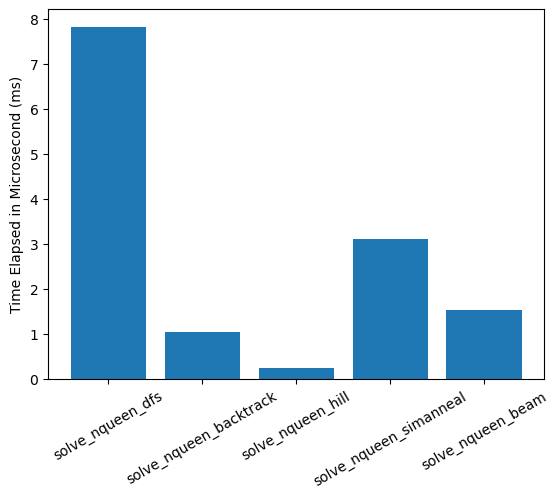

In [17]:
benchmark_nqueen(8, True)

It can be seen from the results that

1. DFS (naive) is the slowest algorithm, because it blindly traverse through too many invalid paths.
2. After pruning the invalid paths from DFS with Backtrack, it becomes one of the fastest algorithms.
3. Greedy local search is very fast, but from the algorithm output we can see this algorithm frequently gets stuck in local minimas, and as a result we have to restart the algorithm for many times.
4. Simulated Annealing is not very fast, because randomly guessed move is not as efficient as the deepest descent (greedy) step.
5. Beam search, as it maintains a group of best candiates, is fast and efficient as well.